In [1]:
import matplotlib
matplotlib.rc('font', size=16)
import matplotlib.pyplot as plt
import analyze
from channel_dict import channel_dict
import numpy as np
from matplotlib import cm
import os

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
bottom_list = [4511, 4688, 4848, 4956, 5039, 5152, 5242, 5358, 5442, 
               5557, 5646, 5755, 5949, 6052, 6169, 6247, 6358, 6446, 
               6550, 6647, 6753, 6834, 6892, 6909, 6938, 6957, 6984, 
               7067, 7100, 7268]

topbulk_list = [4512, 4689, 4851, 4958, 5041, 5154, 5244, 5360, 5444, 
                5559, 5648, 5756, 5950, 6053, 6170, 6248, 6359, 6447,
                6551, 6648, 6754, 6835, 6893, 6910, 6939, 6958, 6985,
                7068, 7101, 7269]

LED_spectrum = None
noise_spectrum = None
run_counter = 0
for run in topbulk_list:
    if not os.path.exists("/home/ershockley/xenon1t/analysis/spe_acceptance/data/run_%d" % run):
        print("Skipping run %d" % run)
        continue
    if LED_spectrum is None:
        charge, LED_spectrum = analyze.get_data_array(run, "LED_charge")
        charge, noise_spectrum = analyze.get_data_array(run, "NOISE_charge")
    else:
        tmp_charge, tmp_LED = analyze.get_data_array(run, "LED_charge")
        tmp_charge, tmp_noise = analyze.get_data_array(run, "NOISE_charge")
        LED_spectrum += tmp_LED
        noise_spectrum += tmp_noise
    run_counter +=1
print("%d runs added to spectra" % run_counter)
        

Skipping run 4512
Skipping run 5950
Skipping run 6053
Skipping run 6170
Skipping run 6248
Skipping run 6359
Skipping run 6447
Skipping run 6551
Skipping run 6648
Skipping run 6754
Skipping run 6835
Skipping run 6893
Skipping run 6910
Skipping run 6939
Skipping run 6958
Skipping run 6985
Skipping run 7068
Skipping run 7101
Skipping run 7269
11 runs added to spectra


In [4]:
print("LED entries: ", LED_spectrum[1].sum())
print("noise entries: ", noise_spectrum[1].sum())


LED entries:  1806775.0
noise entries:  1830516.90706


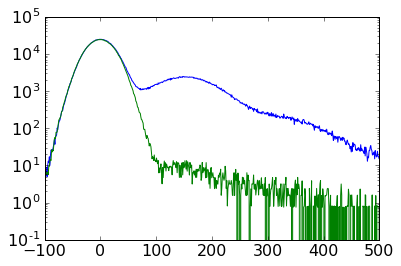

In [7]:
plt.plot(charge, LED_spectrum[0])
plt.plot(charge, noise_spectrum[0])
plt.xlim(-100, 500)
plt.yscale('log')
#plt.ylim(1e4, 3e4)
plt.show()

In [8]:
residual = LED_spectrum - noise_spectrum

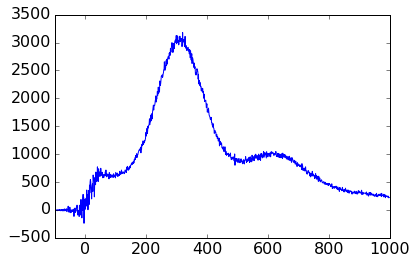

In [31]:
plt.plot(charge, residual[215])
plt.xlim(-100, 1000)
plt.show()

In [176]:
from scipy.interpolate import UnivariateSpline
test = residual[4]

f = UnivariateSpline(charge, test, s=3e6)

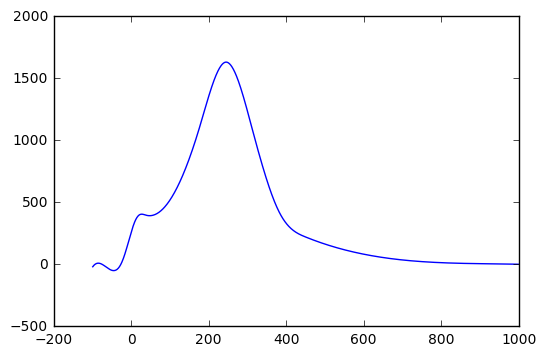

In [177]:
plt.plot(charge, f(charge))
plt.show()

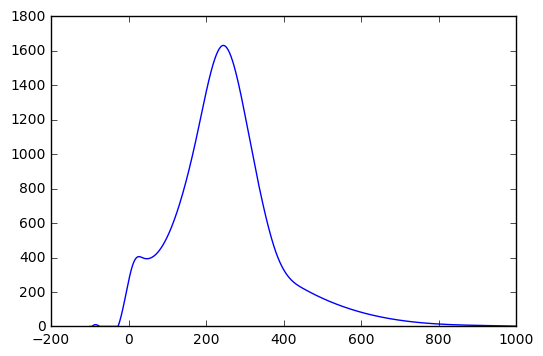

In [201]:
spe_dist = f(charge)
spe_dist = spe_dist.clip(min=0)
plt.plot(charge, spe_dist)
plt.show()

In [203]:
from scipy.optimize import curve_fit

def gauss(x, const, mu, sigma):
    G = const * np.exp(-(x-mu)**2 / (2*sigma**2))
    return G

def fit_with_gauss(xdata, ydata, xmin, xmax, first_guess = None):
    fit_xdata = [x for x in xdata if xmin<x<xmax]
    fit_ydata = [y for i,y in enumerate(ydata) if xmin<xdata[i]<xmax]
    assert len(fit_xdata) == len(fit_ydata)
    par_bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])
    pars, cov = curve_fit(gauss, fit_xdata, fit_ydata, first_guess, bounds = par_bounds)
    return pars, cov

[ 1620.60627188   244.29752363    76.18515467]


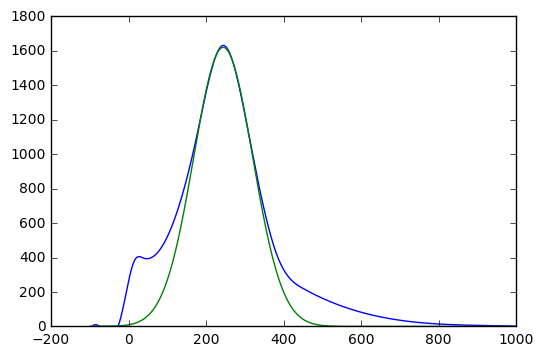

In [212]:
first_guess = [1e3, 250, 50]
popt,pcov = fit_with_gauss(charge,spe_dist, 175, 325, first_guess=first_guess)

print(popt)
fit = [gauss(x, *popt) for x in charge]
plt.plot(charge, spe_dist)
plt.plot(charge, fit)
plt.show()

In [237]:
new_spe = []
for i, (b, spe) in enumerate(zip(charge,spe_dist)):
    if b<popt[1]+popt[2]:
        if b<-50:
            new_spe.append(0.0)
        else:
            new_spe.append(spe)
    else:
        new_spe.append(fit[i])
        
new_spe = np.array(new_spe)


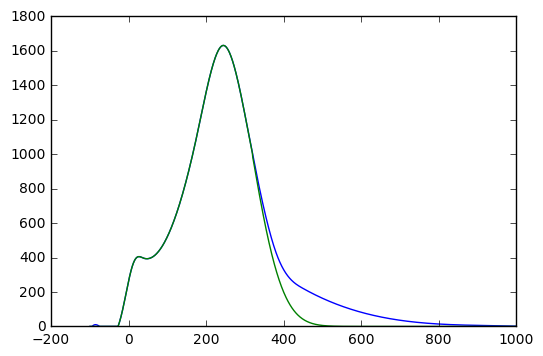

In [245]:
plt.plot(charge, spe_dist)
plt.plot(charge, new_spe)
plt.show()

In [239]:
spe = new_spe
spe = spe / spe.sum()
print(spe.sum())

1.0


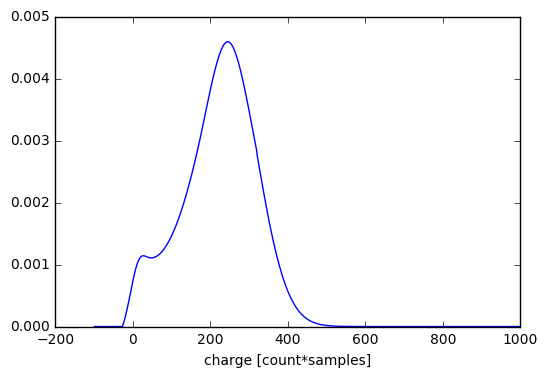

In [244]:
plt.plot(charge, spe)
plt.xlabel('charge [count*samples]')
plt.savefig('sample_spe_dist.png')
plt.show()

In [241]:
with open('spe_distribution.csv', "w") as f:
    for c, p in zip(charge, spe):
        f.write("%0.1f, %0.6f\n" % (c,p)) 